In [7]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import data, color, io, exposure
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.color import rgb2hsv, rgb2gray

from sklearn.cluster import KMeans

[WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/1.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/10.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/11.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/12.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/13.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/14.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/15.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/16.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Challenge/traffic_sign_detection/test_images/17.jpg'), WindowsPath('C:/Users/loren/Documents/AI_BME/Data Chall

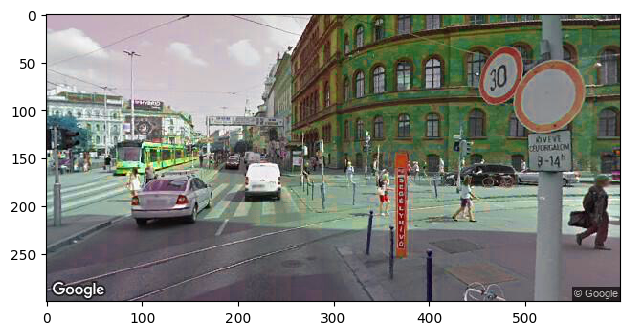

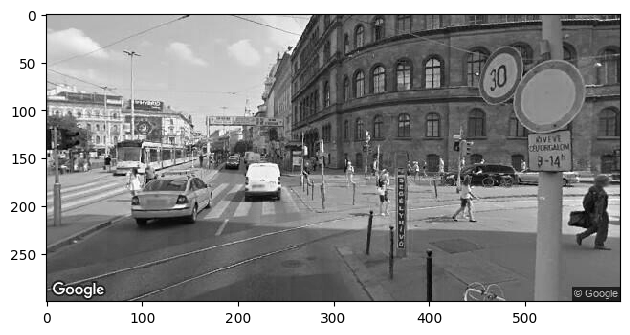

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [20]:
def extract_signs(
    imagepath=r"C:\Users\loren\Documents\AI_BME\traffic\training_images\7.jpg",
    show_plot=False,
    use_cv2=True,
    use_sklearn=True,
):
    # init
    subimages_sklearn = None
    subimages_cv2 = None
    # Load picture
    image_rgb = io.imread(imagepath)
    # Convert the image to the HSV color space
    hsv_image = color.rgb2hsv(image_rgb)

    # Extract the red channel (Hue) from the HSV image
    red_hue = hsv_image[:, :, 0]

    # Perform histogram equalization on the red channel
    red_hue_equalized = exposure.equalize_hist(red_hue)

    # Replace the red channel with the equalized one in the HSV image
    hsv_image[:, :, 0] = red_hue_equalized

    # Convert the HSV image back to RGB
    enhanced_image = color.hsv2rgb(hsv_image)

    # Convert the RGB image to grayscale

    image_gray = rgb2gray(enhanced_image)

    if show_plot:
        io.imshow(enhanced_image)
        io.show()

        io.imshow(image_gray)
        io.show()

    if use_cv2:
        circles_alternative = cv2.HoughCircles(
            cv2.normalize(
                src=image_gray,
                dst=None,
                alpha=0,
                beta=255,
                norm_type=cv2.NORM_MINMAX,
                dtype=cv2.CV_8U,
            ),
            cv2.HOUGH_GRADIENT,
            1,
            15,
            param1=100,
            param2=30,
            minRadius=10,
            maxRadius=30,
        )

        for k in range(len(circles_alternative[0])):
            center_x, center_y, radius = circles_alternative[0, k, :].astype(int)
            circy, circx = circle_perimeter(
                center_y, center_x, radius, shape=image_rgb.shape
            )
            image_rgb[circy, circx] = (20, 20, 200)

        subimages_cv2 = []
        for k in range(len(circles_alternative[0])):
            center_x, center_y, radius = circles_alternative[0, k, :].astype(int)
            small = image_rgb[
                center_y - radius : center_y + radius,
                center_x - radius : center_x + radius,
            ]
            subimages_cv2.append(small)

    if use_sklearn:
        # Detect multiple radii

        hough_radii = np.arange(10, 30, 1)
        edges = canny(image_gray)
        hough_res = hough_circle(edges, hough_radii)

        # Select the most prominent 3 circles per radius

        accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, num_peaks=3)

        circles = np.column_stack((cx, cy, radii))
        circles_cleaned = []
        tolerance_distance = 8

        for cx_1, cy_1, radius_1 in circles:
            temp_circles = []
            for cx_2, cy_2, radius_2 in circles:
                distance = np.linalg.norm(
                    np.array([cx_1, cy_1]) - np.array([cx_2, cy_2])
                )
                if distance < tolerance_distance:
                    temp_circles.append([cx_2, cy_2, radius_2])
            temp_circles = np.mean(temp_circles, axis=0).astype(int)
            circles_cleaned.append(temp_circles)
        circles_cleaned = np.stack(circles_cleaned, axis=0)
        circles_cleaned = np.unique(circles_cleaned, axis=0)

        for center_x, center_y, radius in circles_cleaned:
            circy, circx = circle_perimeter(
                center_y, center_x, radius, shape=image_rgb.shape
            )

            image_rgb[circy, circx] = (20, 200, 20)
            subimages_sklearn = []
        for center_y, center_x, radius in circles_cleaned:
            small = image_rgb[
                center_y - radius : center_y + radius,
                center_x - radius : center_x + radius,
            ]
            subimages_sklearn.append(cv2.resize(small, (50, 50)))

    if show_plot:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
        # Show the image with circles

        ax.imshow(image_rgb)
        plt.show()

    # Extract the parts with circles and store the subimages

    return subimages_cv2, subimages_sklearn


image_path = pathlib.Path(
    r"C:\Users\loren\Documents\AI_BME\Data Challenge\traffic_sign_detection\test_images"
)


image_paths = list(image_path.glob("*.jpg"))
print(image_paths)

for path in image_paths:
    _, _ = extract_signs(path, show_plot=True, use_cv2=True, use_sklearn=True)

In [22]:
a = []
a.append(np.array([1, 2, 3]))